[Car Evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation)

Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making.

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets

In [4]:
X

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


In [6]:
X.nunique()

buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
dtype: int64

In [11]:
y['class'].value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [19]:
df = X.merge(y, left_index=True, right_index=True)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Define the order of the categories for each feature
categories = [
    ['low', 'med', 'high', 'vhigh'],  # buying
    ['low', 'med', 'high', 'vhigh'],  # maint
    ['2', '3', '4', '5more'],  # doors
    ['2', '4', 'more'],  # persons
    ['small', 'med', 'big'],  # lug_boot
    ['low', 'med', 'high']  # safety
]

# Create an instance of OrdinalEncoder with the categories in the correct order
ordinal_features = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
ordinal_transformer = OrdinalEncoder(categories=categories, dtype=np.int8)

# Create a pipeline that includes the OrdinalEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features)
    ])

# Assume df is your DataFrame and the columns are in the same order as categories
# Fit and transform the data using the pipeline
X_encoded = preprocessor.fit_transform(X)

In [35]:
X_encoded

array([[3, 3, 0, 0, 0, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       ...,
       [0, 0, 3, 2, 2, 0],
       [0, 0, 3, 2, 2, 1],
       [0, 0, 3, 2, 2, 2]], dtype=int8)

In [36]:
target_categories = [['unacc', 'acc', 'good', 'vgood']]
target_encoder = OrdinalEncoder(categories=target_categories, dtype=np.int8)
y_encoded = target_encoder.fit_transform(y)

In [37]:
y_encoded

array([[0],
       [0],
       [0],
       ...,
       [0],
       [2],
       [3]], dtype=int8)

In [41]:
from sklearn.feature_selection import chi2

chi2_scores = chi2(X_encoded, y_encoded)

# Create a DataFrame with the chi-squared statistics and p-values
pd.DataFrame({'feature': X.columns, 'chi2': chi2_scores[0], 'pval': chi2_scores[1]}).sort_values('chi2', ascending=False)

,feature,chi2,pval
5,safety,260.303602,3.864827e-56
3,persons,178.041521,2.335580e-38
0,buying,134.554652,5.641706e-29
1,maint,100.252723,1.371371e-21
4,lug_boot,34.263782,1.742744e-07
2,doors,6.893969,7.535522e-02


In [44]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

/Users/gregorysamek/anaconda3/envs/bt-nn/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [46]:
rf.feature_importances_

# Create a DataFrame with the feature names and importance
pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
5,safety,0.306010
3,persons,0.235922
1,maint,0.155332
0,buying,0.151469
4,lug_boot,0.086649
2,doors,0.064618


In [47]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_categories[0]))

              precision    recall  f1-score   support

       unacc       0.99      1.00      0.99       235
         acc       0.99      0.88      0.93        83
        good       0.56      0.91      0.69        11
       vgood       0.88      0.82      0.85        17

    accuracy                           0.96       346
   macro avg       0.85      0.90      0.87       346
weighted avg       0.97      0.96      0.96       346



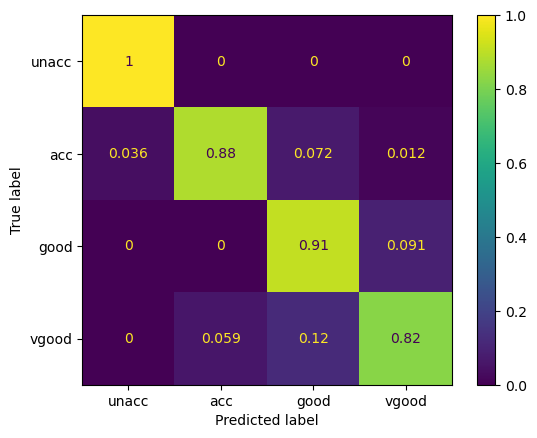

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=target_categories[0], normalize='true')

In [49]:
from sklearn.inspection import permutation_importance

# Calculate the permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame with the feature names and importance
pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean}).sort_values('importance', ascending=False)

,feature,importance
5,safety,0.216474
3,persons,0.215029
0,buying,0.171965
1,maint,0.159249
4,lug_boot,0.080058
2,doors,0.019653


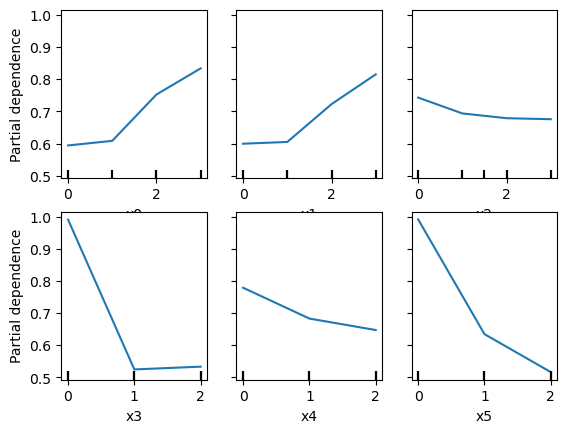

In [94]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test, [0,1,2,3,4,5], target=0)